# <center> Data Preprocessing & Cleaning for Social Media Opinions on Food Security in Malaysia 🌍 </center> 

## 📚 Notebook Overview

This notebook is designed for preparing and cleaning a dataset on social media opinions regarding food security in Malaysia. The main steps are: translating multilingual data to English, cleaning and preprocessing text, performing sentiment annotation with Vader, and splitting the dataset into training and test sets. By the end, we’ll save the preprocessed dataset and pipeline for future use.

#### 🔑 Steps:
1. **Data Translation** : Convert all data to English using Google Translate (because the data is in multiple languages).
2. **Data Cleaning & Preprocessing** : Clean the data by removing unnecessary elements and apply stemming/lemmatization.
3. **Sentiment Scoring** : Use VADER (Valence Aware Dictionary and sEntiment Reasoner) for sentiment scoring.
4. **Risk detection** : Detect high-risk or vulnerable tweets based on sentiment score.
5. **Topic modeling** : Use Latent Dirichlet Allocation (LDA) to discover key themes and discussion topics related to food security.
6. **Geospacial and temporal analysis** :
    * Visualize food security risk levels by location
    * Analyze the average risk level and topic distribution monthly over time to observe trends and changes


## 🛠️ Step 1: Install Required Packages


In [232]:
#pip install polyglot
#pip install pyicu
#pip install pycld2
#pip install morfessor
#pip install contractions
#pip install googletrans
#pip install gensim
#pip install pyLDAvis

## 📚 Step 2: Import Necessary Libraries

In [250]:
import numpy as np
import pandas as pd
import re
import nltk
import contractions
import asyncio
import nest_asyncio
from tqdm.asyncio import tqdm_asyncio
import time
from googletrans import Translator
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from polyglot.detect import Detector
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Initialize lemmatizer, Stemmer and stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# English stopwords
stop_words_en = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 🔍 Step 3: Load and Explore the Dataset

In [3]:
path = '/kaggle/input/sentiment-analysis-for-food-insecurity/food_security_tweets_malaysia.csv'
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75336 entries, 0 to 75335
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  75336 non-null  object 
 1   ID        75336 non-null  float64
 2   Username  75336 non-null  object 
 3   Text      75336 non-null  object 
 4   Location  60755 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


In [4]:
data.head()

,Datetime,ID,Username,Text,Location
0,2022-02-01 00:18:19+00:00,1.490000e+18,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru
1,2022-02-01 00:20:14+00:00,1.490000e+18,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN
2,2022-02-01 01:04:00+00:00,1.490000e+18,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia
3,2022-02-01 01:06:14+00:00,1.490000e+18,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia"
4,2022-02-01 01:20:36+00:00,1.490000e+18,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur


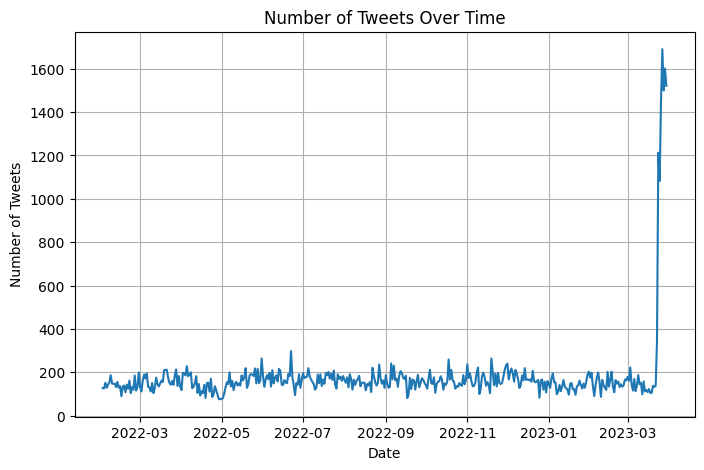

In [5]:
# Convert if not already
datetime = pd.DataFrame()
datetime['Datetime'] = pd.to_datetime(data['Datetime'])

# Group by date only (without time) and count tweets per day
datetime['Date'] = datetime['Datetime'].dt.date
tweet_counts = datetime.groupby('Date').size()

plt.figure(figsize=(8, 5))
tweet_counts.plot()

plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

In [6]:
data = data.drop(['ID'], axis=1)

In [7]:
data = data.drop_duplicates(['Text'] , keep='first')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34103 entries, 0 to 75309
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  34103 non-null  object
 1   Username  34103 non-null  object
 2   Text      34103 non-null  object
 3   Location  28248 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [8]:
def detect_language(text):
    try:
        return Detector(text).language.code
    except:
        return None

languages = pd.DataFrame()      
languages['Code'] = data['Text'].apply(detect_language)

In [9]:
language_counts = languages['Code'].value_counts()
print(language_counts)

Code
en    13124
ms    10225
id     8983
su      274
tl      265
      ...  
ko        1
sw        1
ia        1
eo        1
rn        1
Name: count, Length: 107, dtype: int64


## 🌐 Step 4: Translate Data to English


Since the dataset contains multiple languages, we will use **Google Translate** to convert all text into **English** to ensure consistency and ease of analysis. 

We'll be using the `googletrans` package to perform the translations.

In [10]:
async def translate_text(text):
    async with Translator() as translator:
        result = await translator.translate(text, dest='en')
        return result.text      
    
# Directly calling the async function without asyncio.run() in a Jupyter environment
await translate_text('يا الله i am hungry')

'Oh God I am hungry'

In [11]:
# Allow asyncio to run in notebook
nest_asyncio.apply()

semaphore = asyncio.Semaphore(5)  # Limit concurrency to avoid rate limiting

async def translate_text(text, retries=3):
    async with semaphore:
        for attempt in range(retries):
            try:
                async with Translator() as translator:
                    result = await translator.translate(text, dest='en')
                    return result.text
            except Exception as e:
                await asyncio.sleep(1 + attempt * 2)  # Backoff
                if attempt == retries - 1:
                    return f"ERROR: {str(e)}"

async def translate_column(text_list):
    return await tqdm_asyncio.gather(*(translate_text(text) for text in text_list))

start = time.time()
data['translated_Text'] = await translate_column(data['Text'].tolist())
end  = time.time()
print(f"Translation completed in {(end - start)/60:.2f} minutes")

100%|██████████| 34103/34103 [1:32:30<00:00,  6.14it/s]  

Translation completed in 92.51 minutes


In [25]:
data.head(20)

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text
0,2022-02-01 00:18:19+00:00,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungri r percept action terengganu
1,2022-02-01 00:20:14+00:00,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morn blind siantar hungri want breakfast y...
2,2022-02-01 01:04:00+00:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungri wind alreadi
3,2022-02-01 01:06:14+00:00,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morn clock thought breakfast breakfast h...
4,2022-02-01 01:20:36+00:00,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowli rebuild pace got problem knee injuri su...
6,2022-02-01 01:32:54+00:00,RazakZaha,@ar_zaini3339 Slow tu.. Selalu masalah lapar t...,Kuala Lumpur,@ar_zaini3339 slow tu ... always a hunger prob...,slow tu alway hunger problem tgh run
7,2022-02-01 02:54:44+00:00,teekayzamri,Lalalala lapar nasi (@ Restoran Sambal Hijau i...,Kuala Lumpur,Lalalala Hungry Rice (@ Green Sambal Restauran...,lalalala hungri rice green sambal restaur kual...
8,2022-02-01 03:33:33+00:00,KhaosodEnglish,(2/3) Suwanna said many fear the spill’s arriv...,"Bangkok, Thailand",(2/3) Suwanna said many fear the spill’s arriv...,suwanna said mani fear spill arriv immin peopl...
9,2022-02-01 03:56:07+00:00,StephaninBKK,@hizaga @703pippa Yes! When I go shopping hun...,Bangkok,@hizaga @703pippa Yes! When I go shopping hun...,ye go shop hungri alway get good snack
11,2022-02-01 04:11:09+00:00,cikgu_fadzli,"29 Januari 2022\nPasir Mas, Kelantan.\n\nMisi ...","Besut, Terengganu","January 29, 2022\nPasir Mas, Kelantan.\n\nThe ...",januari pasir ma kelantan mission remov starva...


## 🧹 Step 5: Data Cleaning & Preprocessing

The next step is to clean the data and prepare it for sentiment analysis. We'll perform the following tasks:
- **Remove unnecessary characters** (e.g., URLs, special symbols, emojis).
- **Convert text to lowercase** to maintain uniformity.
- **Remove stop words** to eliminate irrelevant words that don’t contribute to sentiment.
- **Lemmatization**: Lemmatization involves reducing a word to its root form based on its meaning (e.g., "better" → "good", "running" → "run"). It considers the context and the word’s role in a sentence.  It’s more accurate because it always returns a valid word and considers the word's meaning.


> **⚙️ Using a Preprocessing Pipeline :**
>
> To make the preprocessing process modular, reusable, and production-ready, we encapsulate all these steps in a Scikit-learn Pipeline.The same cleaning process can be reused later (e.g., during model inference or deployment) without rewriting code.


In [204]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def expand_contractions(self, text):
        return contractions.fix(text)

    def preprocess_text(self, text):
        text = self.expand_contractions(text)
        text = text.lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'([^\w\s])', r' \1 ', text)
        text = re.sub(r'[^\w\s]', '', text)

        tokens = word_tokenize(text)
        clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_en and word.isalpha()]
        return ' '.join(clean_tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, str):
            return self.preprocess_text(X)
        elif isinstance(X, pd.Series):
            return X.apply(self.preprocess_text)
        elif isinstance(X, list):
            return [self.preprocess_text(text) for text in X]
        else:
            raise TypeError("Input must be a string, list of strings, or pandas Series")

In [205]:
pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor())
])

# Apply the pipeline
data['Cleaned_Text'] = pipeline.fit_transform(data['translated_Text'])

In [317]:
data[['Datetime', 'Username', 'Text', 'Location', 'translated_Text', 'Cleaned_Text']].head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...


## 📈 Step 6: Lexicon-Based Sentiment Analysis Using VADER

For analyzing social media data such as tweets, **VADER (Valence Aware Dictionary and sEntiment Reasoner)** is an excellent choice because it is specifically designed to handle the informal language, slang, emojis, and punctuation often found in tweets. VADER provides a sentiment score that captures positive, negative, neutral, and compound sentiment values, making it effective for understanding overall sentiment in short texts.

We apply VADER to the cleaned text to get a sentiment score for each entry, which will help us quantify public opinion related to food security.


In [218]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    sentiment_label = ''
    if score >= 0.6:
        sentiment_label = 'very positive'
    elif score >= 0.1:
        sentiment_label = 'positive'
    elif -0.1 <= score < 0.1:
        sentiment_label = 'neutral'
    elif score >= -0.6:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'very negative'
    return score, sentiment_label

# Apply sentiment analysis to the cleaned text
data[['sentiment_score', 'sentiment_label']] = data['Cleaned_Text'].apply(get_sentiment).apply(pd.Series)

In [219]:
data.head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,risk_score
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,neutral,Medium,1
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,1
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,neutral,Medium,1
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,neutral,Medium,1
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,2


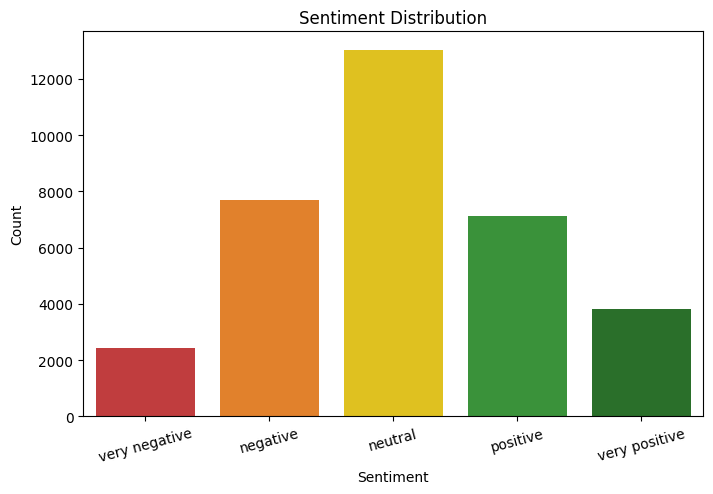

In [220]:
# Define the order and colors for sentiment labels
sentiment_order = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
colors = ['#D62728', '#FF7F0E', '#FFD700', '#2CA02C', '#1F7A1F']  
# red-ish for negative, orange for negative, yellow for neutral, green for positive, darker green for very positive

# Count sentiment occurrences in your dataset
sentiment_counts = data['sentiment_label'].value_counts().reindex(sentiment_order)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.show()

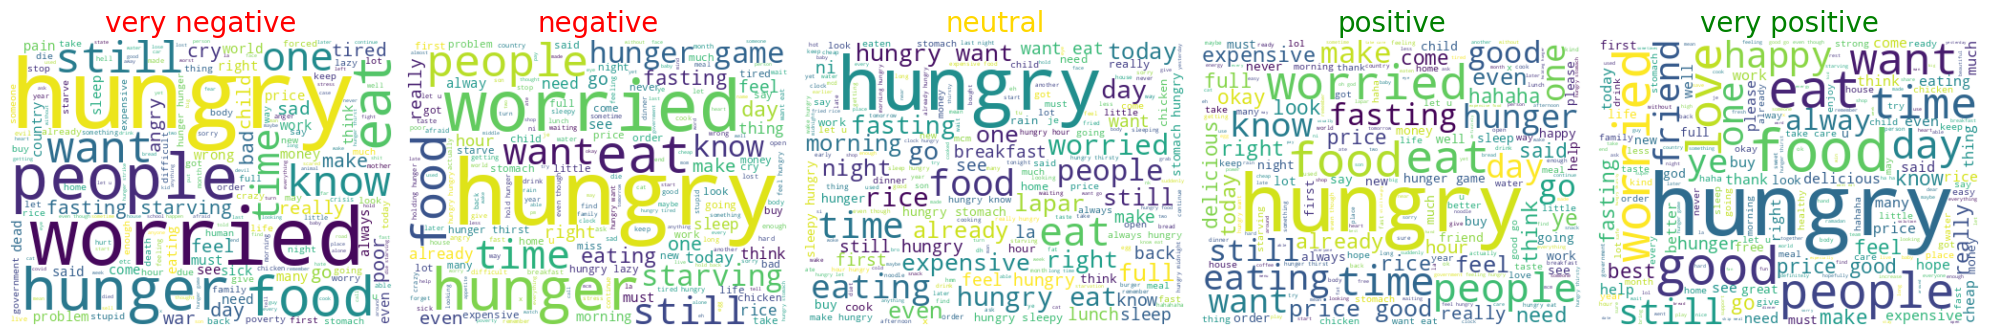

In [221]:
# Sentiment categories in order
sentiment_order = ['very negative', 'negative', 'neutral', 'positive', 'very positive']

# Define color mapping for sentiment labels
label_colors = {
    'very negative': 'red',
    'negative': 'red',
    'neutral': 'gold',
    'positive': 'green',
    'very positive': 'green'
}

plt.figure(figsize=(20, 8))

for i, sentiment in enumerate(sentiment_order, 1):
    # Join all cleaned texts belonging to this sentiment
    text = ' '.join(data.loc[data['sentiment_label'] == sentiment, 'Cleaned_Text'])
    
    # Generate word cloud
    wc = WordCloud(width=400, height=300, background_color='white', colormap='viridis').generate(text)
    
    # Plot subplot
    plt.subplot(1, 5, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(sentiment, fontsize=20, color=label_colors[sentiment])
    plt.axis('off')

plt.tight_layout()
plt.show()

## 🔥 Step 7: Risk Detection Based on Sentiment

In this step, we assess potential risk levels by leveraging the sentiment scores generated using VADER. The idea is that highly negative sentiment may indicate higher concern or distress related to food security. We assign risk levels based on the compound sentiment score:

* High Risk: Strongly negative sentiment (score ≤ -0.6)

* Medium Risk: Mildly negative to neutral sentiment (score between -0.6 and 0)

* Low Risk: Positive sentiment (score > 0)

This risk scoring helps to identify regions or users expressing greater concern, enabling targeted analysis of food security threats across different areas.

In [223]:
def assign_risk_score(sentiment_score):
    # Flip the sentiment polarity so that more negative sentiment = higher risk
    if sentiment_score <= -0.6:
        return 'High'
    elif sentiment_score <= 0:
        return 'Medium'
    else:
        return 'Low'

data['risk_level'] = data['sentiment_score'].apply(assign_risk_score)

In [224]:
data.head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,risk_score
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,neutral,Medium,1
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,1
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,neutral,Medium,1
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,neutral,Medium,1
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,2


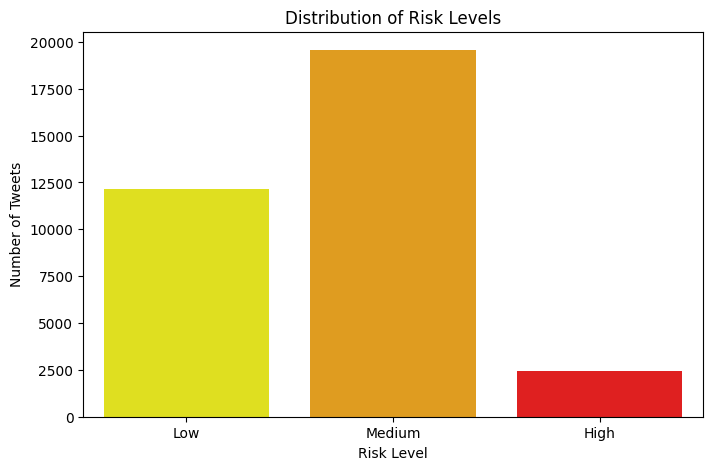

In [225]:
# Define the order and colors for risk levels
risk_order = ['Low', 'Medium', 'High']
risk_colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(8,5))
sns.countplot(data=data, x='risk_level', order=risk_order, palette=risk_colors)

plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Tweets')
plt.show()

## 📝 Step 8: Topic Modelling for Food Insecurity Using LDA

Perform topic modeling on a dataset of text to uncover hidden topics related to food insecurity using **Latent Dirichlet Allocation (LDA)**.

In [261]:
# Prepare the corpus
docs = data['Cleaned_Text'].dropna().tolist()

# Vectorize text into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95,    # ignore very common words
                             min_df=2,       # ignore very rare words
                             stop_words='english')

dtm = vectorizer.fit_transform(docs)

In [278]:
# Fit LDA
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=10,
                                learning_method='batch',
                                random_state=0)
lda.fit(dtm)

LatentDirichletAllocation(n_components=4, random_state=0)

In [279]:
# Display the top words per topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"🔹 Topic #{topic_idx+1}: " + ", ".join(top_words))

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words=30)

🔹 Topic #1: hungry, eat, want, eating, fasting, stomach, time, like, rice, feel, night, morning, hour, hunger, sleep, day, sleepy, know, tired, thirsty, today, really, make, lazy, lunch, hold, cook, fast, breakfast, chicken
🔹 Topic #2: food, price, good, expensive, people, buy, like, rise, cheap, money, want, rising, problem, hunger, increase, thing, know, year, make, feel, cost, need, right, world, assistance, country, government, place, family, meal
🔹 Topic #3: hungry, time, hunger, la, month, worried, fasting, long, good, help, ramadan, stomach, rice, thirst, day, year, order, food, child, best, need, body, je, ni, want, water, week, today, free, looking
🔹 Topic #4: worried, hunger, people, starving, game, like, know, love, really, lapar, make, hungry, life, day, think, want, child, care, going, stay, starve, said, let, happy, need, hope, poor, right, die, power


In [280]:
# Get topic distributions for each document (tweet)
topic_distributions = lda.transform(dtm)

# Assign each tweet to the topic with the highest probability
assigned_topics = np.argmax(topic_distributions, axis=1)

topic_names = {
    0: "Daily Hunger Struggle",
    1: "Food Prices and Economic Hardship",
    2: "Fasting and Food Access Challenges",
    3: "Food insecurity"
}

In [281]:
# Create a new column in your DataFrame for assigned topic
data['assigned_topic'] = [topic_names[i] for i in assigned_topics]

In [282]:
# Count tweets per topic
topic_counts = data['assigned_topic'].value_counts()
print("Number of tweets per topic:")
print(topic_counts)

Number of tweets per topic:
assigned_topic
Daily Hunger Struggle                 17547
Food insecurity                        7780
Food Prices and Economic Hardship      4659
Fasting and Food Access Challenges     4117
Name: count, dtype: int64


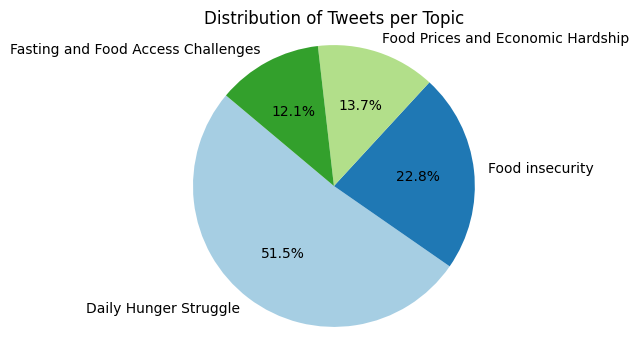

In [284]:
plt.figure(figsize=(4, 4))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Tweets per Topic')
plt.axis('equal')
plt.show()

In [285]:
data.head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,risk_score,assigned_topic
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,neutral,Medium,1,Food insecurity
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,1,Daily Hunger Struggle
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,neutral,Medium,1,Daily Hunger Struggle
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,neutral,Medium,1,Daily Hunger Struggle
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,2,Food insecurity


<Figure size 1200x800 with 0 Axes>

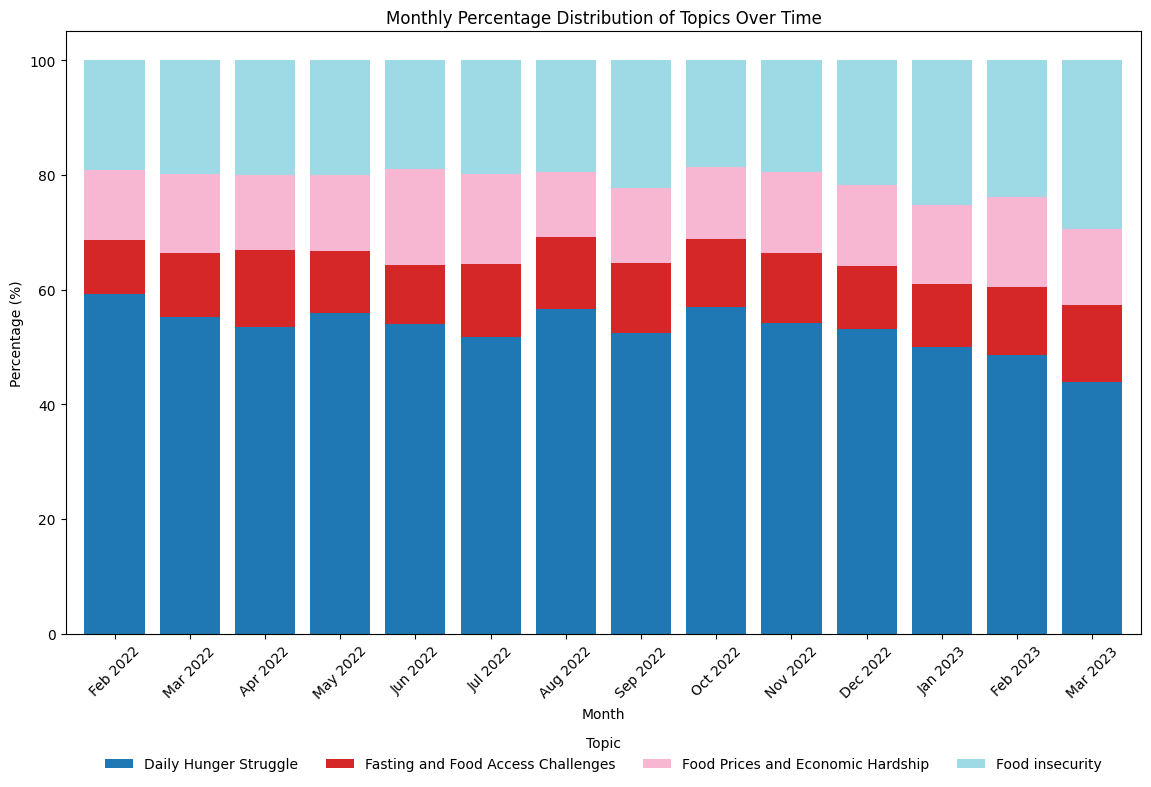

In [312]:
# Ensure Datetime is datetime type 
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Group by month and topic, count tweets
monthly_topic_counts = data.groupby([data['Datetime'].dt.to_period('M'), 'assigned_topic']).size().unstack(fill_value=0)

# Calculate percentage distribution per month
monthly_topic_percent = monthly_topic_counts.div(monthly_topic_counts.sum(axis=1), axis=0) * 100

#  Convert PeriodIndex to Timestamp for plotting
monthly_topic_percent.index = monthly_topic_percent.index.to_timestamp()

# Plot stacked bar chart
plt.figure(figsize=(12, 8))
monthly_topic_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.8, figsize=(12, 8))

plt.title('Monthly Percentage Distribution of Topics Over Time')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.legend(title='Topic', loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=4, frameon=False)
plt.xticks(rotation=45)

# Show all months on x-axis
plt.gca().set_xticks(range(len(monthly_topic_percent.index)))
plt.gca().set_xticklabels([d.strftime('%b %Y') for d in monthly_topic_percent.index])

plt.tight_layout()
plt.show()

## 🌍 Step 9: Geospatial and Temporal Analysis

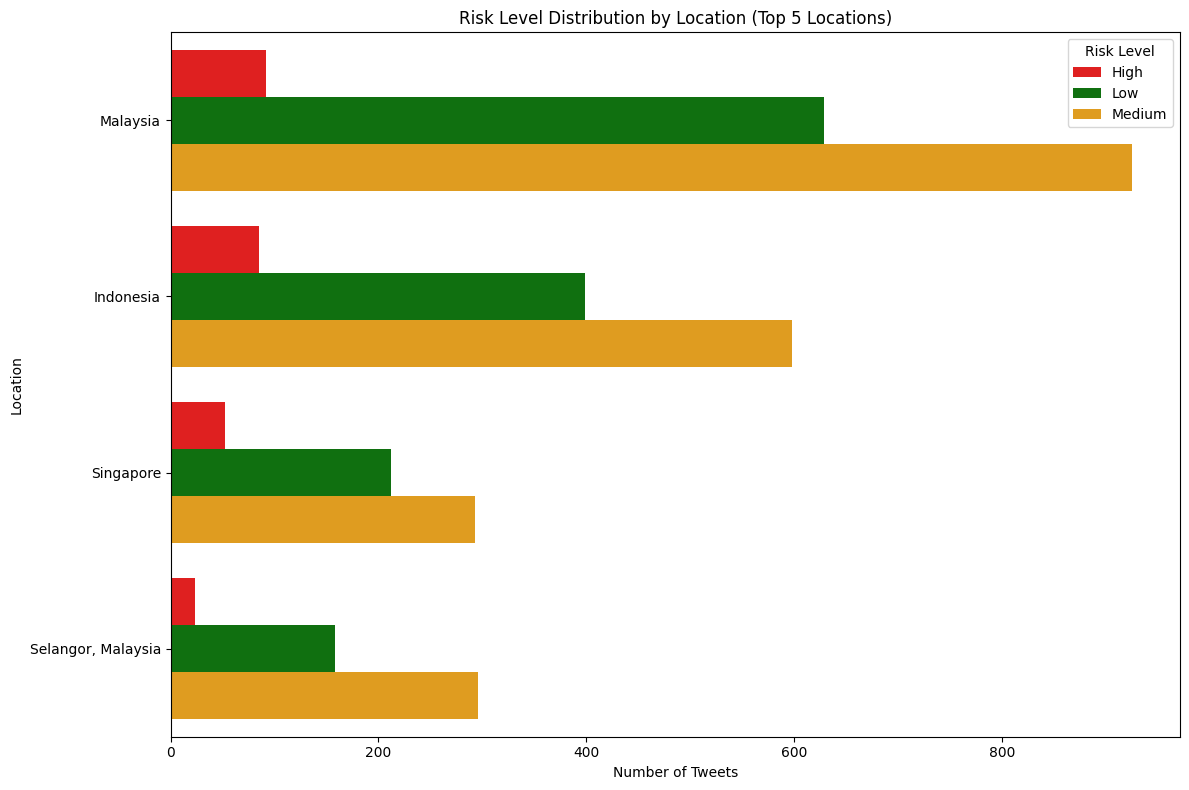

In [226]:
# Fill missing locations
data['Location'] = data['Location'].fillna('Unknown')

# Count the number of tweets per location
location_counts = data['Location'].value_counts().reset_index(name='count')
location_counts.columns = ['Location', 'count']

# Get the top 5 locations
top_5_locations = location_counts.head(5)['Location']

# Filter data to include only top 5 locations
top_5_data = data[data['Location'].isin(top_5_locations)]

# Count of risk levels per location (for top 5 locations only)
risk_counts = top_5_data.groupby(['Location', 'risk_level']).size().reset_index(name='count')

# Exclude 'Unknown' from the plot data, but not from the data itself
risk_counts = top_5_data[top_5_data['Location'] != 'Unknown'].groupby(['Location', 'risk_level']).size().reset_index(name='count')

# Sum the counts by location to sort the locations by total tweet count
location_order = risk_counts.groupby('Location')['count'].sum().sort_values(ascending=False).index

# Set color palette
risk_palette = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=risk_counts, 
            y='Location', 
            x='count', 
            hue='risk_level', 
            palette=risk_palette,
            order=location_order)  # Sort the locations by the total count

plt.title('Risk Level Distribution by Location (Top 5 Locations)')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.legend(title='Risk Level')
plt.tight_layout()
plt.show()


This **horizontal bar chart displays** the distribution of tweets by **risk level** (🔴 High, 🟠 Medium, 🟢 Low) across the **top 5 most active locations**. 

📍 **Malaysia** has the **highest** number of tweets, with the majority being medium and low risk, reflecting a balanced sentiment. Similarly, **Indonesia** shows a large number of tweets, mostly in the medium category. **Singapore and Selangor** have **lower activity**, but still follow a similar risk distribution pattern. 

This visualization gives a clear picture of how risk perception and sentiment vary geographically 🌐.

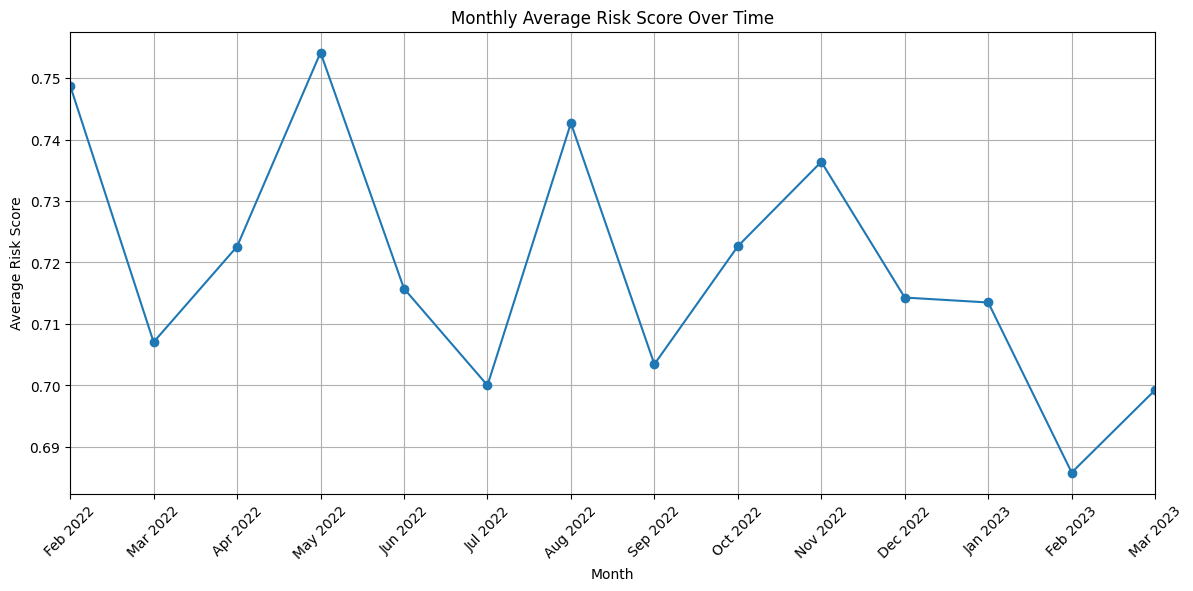

In [227]:
# Map risk levels to numeric scores temporarily for averaging
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
data['risk_score'] = data['risk_level'].map(risk_mapping)

# Make sure datetime column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime']).dt.tz_localize(None)

monthly_risk = data.groupby(data['Datetime'].dt.to_period('M'))['risk_score'].mean()

# Create full month range from min to max date in dataset
full_month_range = pd.period_range(start=data['Datetime'].min().to_period('M'),
                                  end=data['Datetime'].max().to_period('M'),
                                  freq='M')

# Reindex to full range, missing months will have NaN
monthly_risk = monthly_risk.reindex(full_month_range)


# Plot
plt.figure(figsize=(14, 6))
monthly_risk.index = monthly_risk.index.to_timestamp()  # Convert PeriodIndex to Timestamp for plotting
monthly_risk.plot(marker='o')
plt.title('Monthly Average Risk Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Risk Score')
plt.grid(True)

# Customize x-axis to show all months, formatted nicely
plt.xticks(monthly_risk.index, monthly_risk.index.strftime('%b %Y'), rotation=45)

plt.show()


This **line chart** shows the trend of the **average risk score** from **February 2022 to March 2023**. 📊 The risk score based on sentiment polarity (with more negative sentiment meaning higher risk) — generally decreases over time. ⬇️ 

There are noticeable **peaks** in **May 2022 and August 2022**, indicating periods of lower risk or more positive public sentiment.

In contrast, **March 2022 and February 2023** show lower scores, suggesting **higher perceived risk** or negative sentiment. 

If we **compare** the **risk score** with the **number of tweets** in **March 2023**, we notice a huge jump in tweet activity, but the risk score remains low. This means something important likely happened that caused a surge in discussion. However, since the risk score did not rise sharply, it could mean that the event triggered a mix of emotions, or increased public interest without a strong negative reaction.

This analysis helps identify **critical periods** of public concern or **reassurance** over the year and shows that higher tweet volume doesn't always mean higher risk.

## 💾 Step 10: Save the Preprocessed Data and Pipeline

In [313]:
data.head(10)

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,risk_score,assigned_topic
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,neutral,Medium,1,Food insecurity
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,1,Daily Hunger Struggle
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,neutral,Medium,1,Daily Hunger Struggle
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,neutral,Medium,1,Daily Hunger Struggle
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,2,Food insecurity
6,2022-02-01 01:32:54,RazakZaha,@ar_zaini3339 Slow tu.. Selalu masalah lapar t...,Kuala Lumpur,@ar_zaini3339 slow tu ... always a hunger prob...,slow tu always hunger problem tgh running,-0.5719,negative,Medium,1,Daily Hunger Struggle
7,2022-02-01 02:54:44,teekayzamri,Lalalala lapar nasi (@ Restoran Sambal Hijau i...,Kuala Lumpur,Lalalala Hungry Rice (@ Green Sambal Restauran...,lalalala hungry rice green sambal restaurant k...,0.2500,positive,Low,0,Daily Hunger Struggle
8,2022-02-01 03:33:33,KhaosodEnglish,(2/3) Suwanna said many fear the spill’s arriv...,"Bangkok, Thailand",(2/3) Suwanna said many fear the spill’s arriv...,suwanna said many fear spill arrival imminent ...,-0.4767,negative,Medium,1,Food Prices and Economic Hardship
9,2022-02-01 03:56:07,StephaninBKK,@hizaga @703pippa Yes! When I go shopping hun...,Bangkok,@hizaga @703pippa Yes! When I go shopping hun...,yes go shopping hungry always get good snack,0.6808,very positive,Low,0,Food Prices and Economic Hardship
11,2022-02-01 04:11:09,cikgu_fadzli,"29 Januari 2022\nPasir Mas, Kelantan.\n\nMisi ...","Besut, Terengganu","January 29, 2022\nPasir Mas, Kelantan.\n\nThe ...",january pasir ma kelantan mission removing sta...,0.0000,neutral,Medium,1,Food Prices and Economic Hardship


In [318]:
# Save to CSV
data.to_csv('food_security_processed_data.csv', index=False)

In [319]:
# Save the pipeline to a file
joblib.dump(pipeline, 'text_preprocessor_pipeline.joblib')

['text_preprocessor_pipeline.joblib']

> **To Load the saved pipeline**
> 
> loaded_pipeline = joblib.load('text_preprocessor_pipeline.joblib')
> 
> text = "Food aid delays cause hunger! #hunger @aid"
> 
> cleaned_text = pipeline.transform(text)


<center>In this notebook, we've successfully cleaned and preprocessed social media data, translated it to English, and prepared it for sentiment analysis. In the next step, we'll build a sentiment classification model to analyze opinions on food security in Malaysia.</center>